# Set up

## Import

In [1]:
#import
import numpy as np
import pandas as pd

import os
import glob
from rastertodataframe import raster_to_dataframe

from math import floor

from PIL import Image
import matplotlib.pyplot as plt

In [2]:
#custom functions

#function to create histogram of scenes class frequency
def nrcan_hist(img):
    import numpy as np
    import pandas as pd
    from collections import Counter

    im_array = np.array(img)

    #last line is bad values 
    im_array = im_array[:-1]

    #value count
    freq = Counter(im_array.flatten())

    plt.bar(freq.keys(), freq.values())
    plt.xlim([-1, 20])
    
#function to turn tiff to df
def tiff_to_df_colab(path):

    #Create folder path and list variables
    folder_path = path
    file_list = glob.glob(folder_path + "/*.tiff")

    #initiate empty dataframe
    main_dataframe = pd.DataFrame()

    for i in file_list:
        data = raster_to_dataframe(i)
  
        #extract name of band from file path
        band_info = str(i).split('/')[-1]
        band_name = band_info[-14:-11]
        #rename with band name
        data = data.rename(columns = {'Band_1': band_name})
        #merge into main dataframe
        main_dataframe = pd.concat([main_dataframe, data], axis = 1)

    return main_dataframe

## NRCan labels

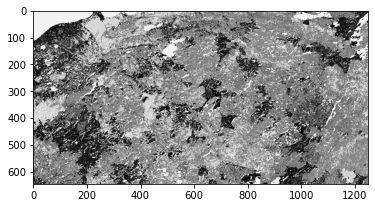

In [3]:
#import selected nrCAN extents
sask_nrcan = Image.open('../data_tests/scene_4/NRCAN_transformed.tif')
#show image
plt.imshow(sask_nrcan, cmap = 'gray', vmin = 0, vmax = 19)

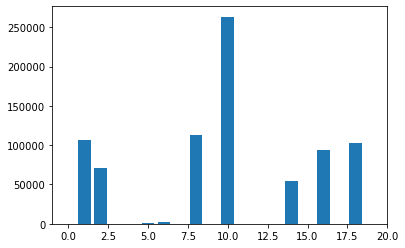

In [4]:
#class histogram plot
nrcan_hist(sask_nrcan)

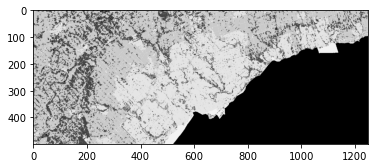

In [5]:
tor_nrcan = Image.open('../data_tests/scene_5/NRCAN_transformed.tif')
#show image
plt.imshow(tor_nrcan, cmap = 'gray', vmin = 0, vmax = 19)

In [6]:
tor_nrcan_df = pd.DataFrame(np.asarray(tor_nrcan))
tor_nrcan_df.tail()

,0,1,2,3,4,5,6,7,8,9,...,1240,1241,1242,1243,1244,1245,1246,1247,1248,1249
494,17,17,16,17,17,17,17,17,17,17,...,0,0,0,0,0,0,0,0,0,0
495,17,17,16,17,17,17,17,17,17,17,...,0,0,0,0,0,0,0,0,0,0
496,17,17,17,17,17,17,17,17,17,17,...,0,0,0,0,0,0,0,0,0,0
497,17,17,17,17,17,17,17,17,17,17,...,0,0,0,0,0,0,0,0,0,0
498,17,17,17,17,17,17,17,15,17,17,...,0,0,0,0,0,0,0,0,0,0


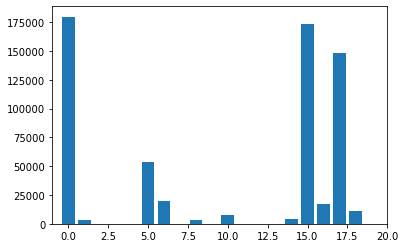

In [7]:
#class histogram plot
nrcan_hist(tor_nrcan)

## Raw bands

In [8]:
#load in raw bands
sask_raws = tiff_to_df_colab('../data_tests/scene_4/raws')
tor_raws = tiff_to_df_colab('../data_tests/scene_5/raws')

sask_raws.head()

,B01,B02,B03,B04,B05,B06,B07,B08,B09,B11,B12,B8A
0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
1,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2,0.0481,0.0393,0.0398,0.0185,0.0172,0.0133,0.0136,0.0129,0.0179,0.0075,0.0068,0.0120
3,0.0462,0.0355,0.0382,0.0178,0.0157,0.0123,0.0120,0.0123,0.0157,0.0072,0.0059,0.0108
4,0.0421,0.0356,0.0381,0.0180,0.0160,0.0124,0.0118,0.0135,0.0162,0.0072,0.0066,0.0112


In [9]:
#convert nrcan extents to 1 dimension array
sask_labels = np.asarray(sask_nrcan).reshape(len(sask_raws))
tor_labels = np.asarray(tor_nrcan).reshape(len(tor_raws))

#add label column
sask_raws['y'] = sask_labels
tor_raws['y'] = tor_labels

tor_raws.head()

,B01,B02,B03,B04,B05,B06,B07,B08,B09,B11,B12,B8A,y
0,0.0934,0.1228,0.1588,0.2052,0.2344,0.2549,0.2729,0.2928,0.2947,0.3868,0.3853,0.2917,15
1,0.0890,0.1163,0.1507,0.1944,0.2210,0.2390,0.2560,0.2761,0.2777,0.3842,0.3827,0.2757,15
2,0.0893,0.1157,0.1511,0.1944,0.2199,0.2363,0.2552,0.2752,0.2764,0.3886,0.3842,0.2765,15
3,0.1104,0.1609,0.1919,0.2144,0.2526,0.2926,0.3128,0.3342,0.3254,0.3672,0.3320,0.3325,15
4,0.0723,0.0913,0.1220,0.1250,0.1730,0.2769,0.3134,0.3368,0.3366,0.3020,0.2353,0.3376,15


# EDA

In [10]:
#in nrcan Nulls translate as 0
print((sask_raws.loc[sask_raws['y'] == 0]).empty) #none in sask extent
print((tor_raws.loc[tor_raws['y'] == 0]).empty) #there are in tor

#in this case they all correspond to water
tor_raws['y'] = tor_raws['y'].replace({0:18})
print((tor_raws.loc[tor_raws['y'] == 0]).empty) #all converted to water

True
False
True


In [11]:
sask_raws.describe()

,B01,B02,B03,B04,B05,B06,B07,B08,B09,B11,B12,B8A,y
count,807500.000000,807500.000000,807500.000000,807500.000000,807500.000000,807500.000000,807500.000000,807500.000000,807500.000000,807500.000000,807500.000000,807500.000000,807500.000000
mean,0.024876,0.029350,0.044957,0.047224,0.081303,0.126697,0.139107,0.153081,0.157385,0.147388,0.099789,0.154952,9.803503
std,0.019450,0.021947,0.027437,0.037839,0.043430,0.055700,0.059944,0.065556,0.065299,0.067283,0.059750,0.065668,5.502670
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.015100,0.019200,0.035000,0.034300,0.069500,0.111500,0.122200,0.134500,0.138600,0.124300,0.070700,0.136700,8.000000
50%,0.021900,0.025800,0.042000,0.043900,0.082900,0.133400,0.146000,0.160300,0.164200,0.154300,0.096100,0.162600,10.000000
75%,0.030300,0.034700,0.050500,0.054300,0.094400,0.151900,0.167100,0.183900,0.188300,0.183200,0.128900,0.186200,14.000000
max,0.360500,0.353300,0.447600,0.620900,0.657900,0.653900,0.653900,0.686900,0.657000,0.712800,0.724800,0.655000,18.000000


In [12]:
tor_raws.describe()

,B01,B02,B03,B04,B05,B06,B07,B08,B09,B11,B12,B8A,y
count,623750.000000,623750.000000,623750.00000,623750.000000,623750.000000,623750.000000,623750.000000,623750.000000,623750.000000,623750.000000,623750.000000,623750.000000,623750.000000
mean,0.052211,0.062704,0.07934,0.073634,0.106254,0.195029,0.226777,0.240479,0.242453,0.170198,0.123797,0.239476,15.089565
std,0.029131,0.036134,0.04156,0.055365,0.060399,0.114469,0.141020,0.150475,0.152005,0.105685,0.091837,0.150902,4.080086
min,0.007400,0.010600,0.01080,0.004800,0.004000,0.001600,0.003200,0.003500,0.002100,0.001600,0.000900,0.003100,1.000000
25%,0.032900,0.039200,0.05120,0.034500,0.049700,0.048400,0.048700,0.049900,0.047500,0.045200,0.041700,0.047400,15.000000
50%,0.046600,0.053500,0.06810,0.051300,0.106700,0.226100,0.255700,0.271800,0.275800,0.187200,0.106400,0.271400,17.000000
75%,0.064000,0.077100,0.09880,0.100700,0.138700,0.283800,0.335600,0.357700,0.361800,0.231800,0.163900,0.358100,18.000000
max,0.819600,0.882500,0.88130,1.020600,1.169600,1.216000,1.249300,1.040200,1.277100,1.225300,1.320100,1.231200,18.000000


In [13]:
sask_classes = sask_raws.value_counts('y')
print(sask_classes)

y 
10    263763
8     112554
1     106576
18    102764
16     93449
2      70645
14     54860
6       1682
5       1088
17        93
12        26
dtype: int64


In [14]:
tor_classes = tor_raws.value_counts('y')
print(tor_classes)

y 
18    191484
15    173872
17    148851
5      54154
6      19558
16     17143
10      7565
14      4040
8       3594
1       3489
dtype: int64


In [15]:
#vertical concat
main_dataframe = pd.concat([sask_raws, tor_raws])

print(main_dataframe.shape)
main_classes = main_dataframe.value_counts('y').sort_index() 
print(main_classes)

(1431250, 13)
y 
1     110065
2      70645
5      55242
6      21240
8     116148
10    271328
12        26
14     58900
15    173872
16    110592
17    148944
18    294248
dtype: int64


In [16]:
#select classes above threshold
main_top_classes = main_classes[main_classes > 20000].reset_index().y

#save dataframe subset of those classes
main_subset = main_dataframe.loc[main_dataframe['y'].isin(main_top_classes.values)]

#take smallest value rounded down to nearest 1000
smallest_class = int(floor(min(main_subset.value_counts('y').sort_index().values)/ 1000)) * 1000
#subsampling
smallest_class = 2000

#take subset of each class equal to smallest class value
data = main_subset.groupby("y").sample(n=smallest_class, random_state=1)
print(data.shape)
data.value_counts('y').sort_index() #still missing 11, 12, 13, 19

(22000, 13)


y 
1     2000
2     2000
5     2000
6     2000
8     2000
10    2000
14    2000
15    2000
16    2000
17    2000
18    2000
dtype: int64

# Modelling

Random Forest, SVC, XGBoost [stretch] CNN

## Initial run

In [42]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn import svm, datasets

In [34]:
y = data.y
X = data.drop('y', axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, train_size=0.8, random_state = 0)

### SVC

In [35]:
#Different SVC kernels - sig performed less then 1 percent on subsample so its removed
linear = svm.SVC(kernel='linear', C=1, decision_function_shape='ovo').fit(X_train, y_train)
rbf = svm.SVC(kernel='rbf', gamma=1, C=1, decision_function_shape='ovo').fit(X_train, y_train)
poly = svm.SVC(kernel='poly', degree=3, C=1, decision_function_shape='ovo').fit(X_train, y_train)
#sig = svm.SVC(kernel='sigmoid', C=1, decision_function_shape='ovo').fit(X_train, y_train)

In [36]:
#predict from X_test
linear_pred = linear.predict(X_test)
poly_pred = poly.predict(X_test)
rbf_pred = rbf.predict(X_test)
#sig_pred = sig.predict(X_test)

In [57]:
# retrieve the accuracy and print it for all 4 kernel functions
accuracy_lin = linear.score(X_test, y_test)
accuracy_poly = poly.score(X_test, y_test)
accuracy_rbf = rbf.score(X_test, y_test)
#accuracy_sig = sig.score(X_test, y_test)

# creating a confusion matrix
cm_lin = confusion_matrix(y_test, linear_pred)
cm_poly = confusion_matrix(y_test, poly_pred)
cm_rbf = confusion_matrix(y_test, rbf_pred)
#cm_sig = confusion_matrix(y_test, sig_pred)

#visual confusion matrix
cm_lin_fig = ConfusionMatrixDisplay(confusion_matrix = cm_lin, display_labels = linear.classes_)
cm_poly_fig = ConfusionMatrixDisplay(confusion_matrix = cm_poly, display_labels = poly.classes_)
cm_rbf_fig = ConfusionMatrixDisplay(confusion_matrix = cm_rbf, display_labels = rbf.classes_)

0.19272727272727272
0.19113636363636363
0.1965909090909091


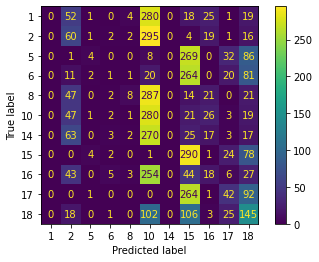

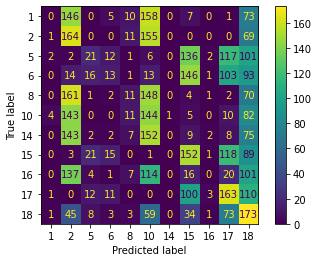

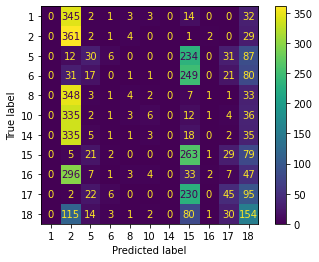

In [60]:
print(accuracy_lin)
cm_lin_fig.plot()
print(accuracy_poly)
cm_poly_fig.plot()
print(accuracy_rbf)
cm_rbf_fig.plot()

### Random Forest

In [61]:
from sklearn.ensemble import RandomForestClassifier

0.17181818181818181


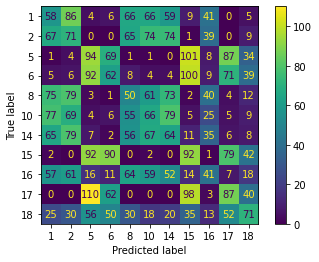

In [71]:
forest = RandomForestClassifier(random_state = 0).fit(X_train, y_train)

#get accuracy
accuracy_forest = forest.score(X_test, y_test)
print(accuracy_forest)

#plot confusion matrix
forest_pred = forest.predict(X_test)
cm_forest = confusion_matrix(y_test, forest_pred)
cm_forest_fig = ConfusionMatrixDisplay(confusion_matrix = cm_forest, display_labels = forest.classes_)
cm_forest_fig.plot()

### XGBoost

In [68]:
import xgboost as xgb

In [99]:
xg_classes = list(range(len(y_train.unique())))

xg_y_train = y_train.replace(y_train.unique(), xg_classes)
xg_y_test = y_test.replace(y_test.unique(), xg_classes)

0.0834090909090909


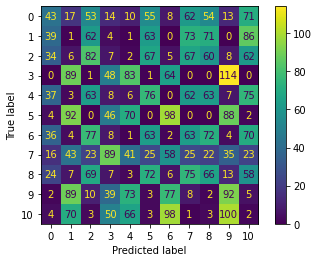

In [101]:
xg_cl = xgb.XGBClassifier().fit(X_train, xg_y_train)

#get accuracy
accuracy_xgb = xg_cl.score(X_test, xg_y_test)
print(accuracy_xgb)

#plot confusion matrix
xgb_pred = xg_cl.predict(X_test)
cm_xgb = confusion_matrix(xg_y_test, xgb_pred)
cm_xgb_fig = ConfusionMatrixDisplay(cm_xgb)
cm_xgb_fig.plot()